In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_LSTM import gw_LSTM
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

2023-11-22 13:24:53.864314: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 13:24:53.897291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 13:24:53.897315: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 13:24:53.897342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 13:24:53.903506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 13:24:53.903876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = data_prep.select_features(pd.read_pickle('../data/pickled_data/AFL259_short.pkl'))
df = data_prep.add_toy_signal(df).set_index('date')

TEST_SIZE = 365 # size of the test set 

X_train = df[:-TEST_SIZE].copy()
X_test = df[-TEST_SIZE:].copy()

y_train = X_train.avg_well_depth.copy().values
y_test = X_test.avg_well_depth.copy().values

well_tr_mean = np.mean(X_train.avg_well_depth.values)
well_tr_std = np.std(X_train.avg_well_depth.values)

In [3]:
X_train, y_train

(            avg_well_depth  gage_ht  discharge_cfs  prcp   temp_avg  \
 date                                                                  
 2005-08-21       99.059167    17.02          600.0   0.0  75.903750   
 2005-08-22       99.163333    17.02          599.0   0.0  72.854167   
 2005-08-23       99.155000    17.02          598.0   0.0  65.272083   
 2005-08-24       99.100417    17.02          601.0   0.0  63.355000   
 2005-08-25       99.147500    17.06          630.0   0.0  66.545000   
 ...                    ...      ...            ...   ...        ...   
 2016-09-24       92.195417    17.84         1350.0   0.0  55.632083   
 2016-09-25       92.147500    17.85         1370.0   0.0  62.652917   
 2016-09-26       92.120833    17.85         1360.0   0.0  64.602083   
 2016-09-27       92.077917    17.85         1370.0   0.0  66.607500   
 2016-09-28       92.052500    17.86         1380.0   0.0  64.323750   
 
               hum_avg      hPa_avg   wind_avg  gust_avg  prcp

In [4]:
scaler =  StandardScaler(copy=True)

#some small parameters, we're just checking that the class works
gw_LSTM = gw_LSTM(WINDOW_SIZE=15,
                 LSTM_UNITS=64,
                 NUM_FEATS=12,
                 D_MAX_LAYERS = 1, D_TOP_UNITS = 8, D_MIN_UNITS=2,
                 D_UNIT_SCALE = 0.5,
                 LEARNING_RATE=0.01, 
                 EPOCHS=20, 
                 RANDOM_STATE = 90210,
                 CHECKPOINT = False,
                 tmean = well_tr_mean,
                 tsd = well_tr_std)

# Cross validation splits
N_SPLITS = 3

## For splitting the data
tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=365, gap=0)


## Set up the pipeline
pipe = Pipeline([('scaler', scaler), ('model', gw_LSTM)])

In [5]:
## Cross validate
mses_cnn = np.zeros(N_SPLITS)

i = 0
for train, test in tscv.split(np.array(X_train), y_train):
    ## Split the data into train/test sets
    X_tt = np.array(X_train)[train]
    y_tt = np.array(y_train)[train]
    X_ho = np.array(X_train)[test]
    y_ho = np.array(y_train)[test]

    ## Fit the model
    pipe.fit(X_tt,y_tt)

    ## Make predictions
    pred = pipe.predict(X_ho)

    ## Score the model
    mse = np.mean((y_ho - pred)**2)
    mses_cnn[i] = mse

    i += 1

2023-11-22 13:24:55.754761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 13:24:55.755688: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
89/89 [==============================] - 2s 4ms/step - loss: 1602.4727 - root_mean_squared_error: 40.0309
Epoch 2/20
89/89 [==============================] - 0s 4ms/step - loss: 13.4616 - root_mean_squared_error: 3.6690
Epoch 3/20
89/89 [==============================] - 0s 4ms/step - loss: 11.3208 - root_mean_squared_error: 3.3646
Epoch 4/20
89/89 [==============================] - 0s 4ms/step - loss: 10.3089 - root_mean_squared_error: 3.2107
Epoch 5/20
89/89 [==============================] - 0s 4ms/step - loss: 9.6212 - root_mean_squared_error: 3.1018
Epoch 6/20
89/89 [==============================] - 0s 4ms/step - loss: 8.8208 - root_mean_squared_error: 2.9700
Epoch 7/20
89/89 [==============================] - 0s 4ms/step - loss: 8.1220 - root_mean_squared_error: 2.8499
Epoch 8/20
89/89 [==============================] - 0s 4ms/step - loss: 7.4419 - root_mean_squared_error: 2.7280
Epoch 9/20
89/89 [==============================] - 0s 4ms/step - loss: 6.7560 - root_mea

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Epoch 1/20
101/101 [==============================] - 2s 4ms/step - loss: 1158.7008 - root_mean_squared_error: 34.0397
Epoch 2/20
101/101 [==============================] - 0s 4ms/step - loss: 13.1921 - root_mean_squared_error: 3.6321
Epoch 3/20
101/101 [==============================] - 0s 4ms/step - loss: 13.2566 - root_mean_squared_error: 3.6410
Epoch 4/20
101/101 [==============================] - 0s 4ms/step - loss: 13.2428 - root_mean_squared_error: 3.6391
Epoch 5/20
101/101 [==============================] - 0s 4ms/step - loss: 13.2494 - root_mean_squared_error: 3.6400
Epoch 6/20
101/101 [==============================] - 0s 4ms/step - loss: 13.4301 - root_mean_squared_error: 3.6647
Epoch 7/20
101/101 [==============================] - 0s 4ms/step - loss: 13.2830 - root_mean_squared_error: 3.6446
Epoch 8/20
101/101 [==============================] - 0s 4ms/step - loss: 13.3024 - root_mean_squared_error: 3.6472
Epoch 9/20
101/10

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Epoch 1/20
112/112 [==============================] - 2s 4ms/step - loss: 2292.7712 - root_mean_squared_error: 47.8829
Epoch 2/20
112/112 [==============================] - 0s 4ms/step - loss: 10.5362 - root_mean_squared_error: 3.2459
Epoch 3/20
112/112 [==============================] - 0s 4ms/step - loss: 7.4121 - root_mean_squared_error: 2.7225
Epoch 4/20
112/112 [==============================] - 0s 4ms/step - loss: 6.5951 - root_mean_squared_error: 2.5681
Epoch 5/20
112/112 [==============================] - 0s 4ms/step - loss: 3.0569 - root_mean_squared_error: 1.7484
Epoch 6/20
112/112 [==============================] - 0s 4ms/step - loss: 0.7055 - root_mean_squared_error: 0.8400
Epoch 7/20
112/112 [==============================] - 0s 4ms/step - loss: 0.2818 - root_mean_squared_error: 0.5309
Epoch 8/20
112/112 [==============================] - 0s 4ms/step - loss: 0.2409 - root_mean_squared_error: 0.4908
Epoch 9/20
112/112 [===

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


In [6]:
mses_cnn

array([26.63192433, 23.07260288, 11.89333358])

In [7]:
## Training on the whole data set   
pipe.fit(X_train,y_train)

## Making a prediction on the holdout set
pred = pipe.predict(X_test)

score = np.sqrt(np.mean((y_test - pred)**2))

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

Epoch 1/20
123/123 [==============================] - 2s 4ms/step - loss: 1331.5919 - root_mean_squared_error: 36.4910
Epoch 2/20
123/123 [==============================] - 0s 4ms/step - loss: 6.8995 - root_mean_squared_error: 2.6267
Epoch 3/20
123/123 [==============================] - 0s 4ms/step - loss: 3.0003 - root_mean_squared_error: 1.7321
Epoch 4/20
123/123 [==============================] - 0s 4ms/step - loss: 2.3469 - root_mean_squared_error: 1.5320
Epoch 5/20
123/123 [==============================] - 0s 4ms/step - loss: 2.2756 - root_mean_squared_error: 1.5085
Epoch 6/20
123/123 [==============================] - 0s 4ms/step - loss: 2.2540 - root_mean_squared_error: 1.5013
Epoch 7/20
123/123 [==============================] - 0s 4ms/step - loss: 2.2349 - root_mean_squared_error: 1.4950
Epoch 8/20
123/123 [==============================] - 0s 4ms/step - loss: 2.2180 - root_mean_squared_error: 1.4893
Epoch 9/20
123/123 [==============================] - 0s 4ms/step - loss: 2.

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step





 This model has a root mean square error of 1.5769025928406253 when evaluated on the holdout data


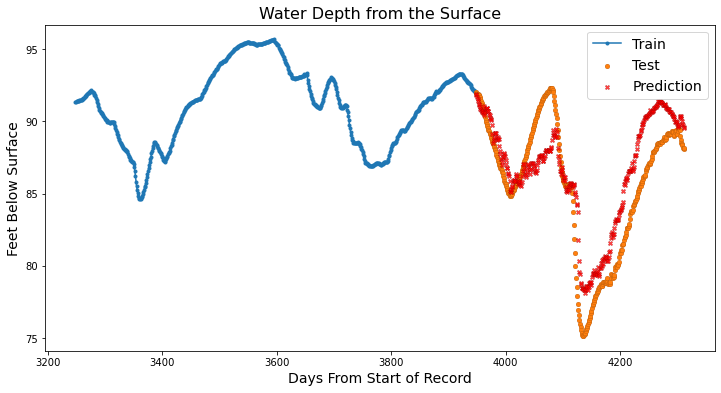

In [8]:
print('\n\n\n',f'This model has a root mean square error of {np.sqrt(score)} when evaluated on the holdout data')

gw_plot(train = y_train, test = y_test, pred = pred,train_limit=700)